### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline
sys.path.append("..")

from utils import label_map_util
from utils import visualization_utils as vis_util
from utils import path_detection_utils as path_util

### Loading in model 

In [2]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

### Object Detection on specific frame

In [3]:
path1 = 'video_frames/frame199.jpg'
path2 = 'video_frames/frame200.jpg'
path3 = 'video_frames/frame201.jpg'

path4 = 'test_images/pic.jpg'

image1 = Image.open(path1)
width1, height1 = image1.size
image_np1 = path_util.load_image_into_numpy_array(image1)
boxes1, scores1, classes1 = path_util.get_segmentation(path1,detection_graph, category_index, False)
human_boxes1, human_scores1 = path_util.remove_non_human(boxes1, scores1, classes1)
good_boxes1, good_scores1 = path_util.remove_low_prob(human_boxes1, human_scores1)
good_boxes1, good_scores1 = path_util.remove_poorly_sized_people(good_boxes1, good_scores1)

image2 = Image.open(path2)
width2, height2 = image2.size
image_np2 = path_util.load_image_into_numpy_array(image2)
boxes2, scores2, classes2 = path_util.get_segmentation(path2,detection_graph, category_index, False)
human_boxes2, human_scores2 = path_util.remove_non_human(boxes2, scores2, classes2)
good_boxes2, good_scores2 = path_util.remove_low_prob(human_boxes2, human_scores2)
good_boxes2, good_scores2 = path_util.remove_poorly_sized_people(good_boxes2, good_scores2)

image3 = Image.open(path3)
width3, height3 = image3.size
image_np3 = path_util.load_image_into_numpy_array(image3)
boxes3, scores3, classes3 = path_util.get_segmentation(path3,detection_graph, category_index, False)
human_boxes3, human_scores3 = path_util.remove_non_human(boxes3, scores3, classes3)
good_boxes3, good_scores3 = path_util.remove_low_prob(human_boxes3, human_scores3)
good_boxes3, good_scores3 = path_util.remove_poorly_sized_people(good_boxes3, good_scores3)

In [4]:
print(len(good_boxes1))
print(len(good_boxes2))
print(len(good_boxes3))

4
7
5


In [23]:
in_frame = [0,1,2,3]
available_people = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22][::-1]
in_frame_details = {}
in_frame_details[in_frame[0]] = good_boxes1[0]
in_frame_details[in_frame[1]] = good_boxes1[1]
in_frame_details[in_frame[2]] = good_boxes1[2]
in_frame_details[in_frame[3]] = good_boxes1[3]
magic_number = 0.05
# dealing with frame 2
sim_scores = []
for i in range(len(in_frame)):
    box_i = in_frame_details[in_frame[i]]
    #print(box_i)
    for j in range(len(good_boxes2)):
        sim_scores.append((in_frame[i], j, path_util.get_box_similarity_score(box_i, good_boxes2[j],0,0,0,0)))

sim_scores = sorted(sim_scores, key=lambda x: x[2])
sim_scores_good = [i for i in sim_scores if i[2] < magic_number]

matched_old = []
matched_new_idx = []
for score in sim_scores_good:
    if score[0] not in matched_old and score[1] not in matched_new_idx:
        in_frame_details[score[0]] = good_boxes2[score[1]]
        matched_old.append(score[0])
        matched_new_idx.append(score[1])
# remove stuff that was not matched
for i in in_frame:
    if i not in matched_old:
        del in_frame_details[i]
        
# add people that were not matched
for i in range(len(good_boxes2)):
    if i not in matched_new_idx:
        new_person = available_people.pop()
        matched_old.append(new_person)
        in_frame_details[new_person] = good_boxes2[i]
in_frame = matched_old

In [25]:
in_frame_details

{0: array([ 0.655168  ,  0.74326456,  0.92519003,  0.93742764], dtype=float32),
 1: array([ 0.71854341,  0.        ,  0.97870278,  0.23217523], dtype=float32),
 2: array([ 0.70316559,  0.56072158,  0.82191604,  0.65528816], dtype=float32),
 3: array([ 0.71940386,  0.47121748,  0.8168242 ,  0.55517048], dtype=float32),
 4: array([ 0.70278507,  0.64170319,  0.8143031 ,  0.68798596], dtype=float32),
 5: array([ 0.58517653,  0.83745104,  0.80861634,  0.99801975], dtype=float32),
 6: array([ 0.69818056,  0.670982  ,  0.8459512 ,  0.75879633], dtype=float32)}

In [21]:
available_people = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
x = available_people.pop()
print(x)
print(available_people)

22
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


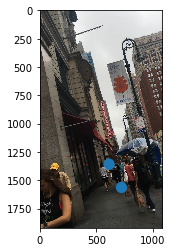

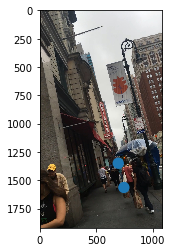

In [17]:
path_util.draw_box(good_boxes1[2], width1, height1, image_np1)
path_util.draw_box(good_boxes2[3], width2, height2, image_np2)

In [4]:
frame_data = []
available_people = range(500)[::-1] # max distinct people we will evaluate across all videos
in_frame = []
in_frame_not_matched = []
in_frame_details = {}

In [5]:
sys.maxint

9223372036854775807

In [15]:
path = 'video_frames/frame'
frame_range = range(501)
all_data = []
for i in frame_range:
    filename = path + str(i) + '.jpg'
    image = Image.open(filename)
    width, height = image.size # not sure if this is worth using
    image_np = path_util.load_image_into_numpy_array(image)
    boxes, scores, classes = path_util.get_segmentation(filename,detection_graph, category_index, False)
    human_boxes, human_scores = path_util.remove_non_human(boxes, scores, classes)
    good_boxes, good_scores = path_util.remove_low_prob(human_boxes, human_scores)
    good_boxes, good_scores = path_util.remove_poorly_sized_people(good_boxes, good_scores)
    ## go through in_frame to see if those match anything in good_boxes
    sim_scores = []
    for i in range(len(in_frame)):
        box_i = in_frame_details[in_frame[i]][0]
        for j in range(len(good_boxes)):
            sim_scores.append((in_frame[i], j, path_util.get_box_similarity_score(box_i, good_boxes[j],0,0,0,0)))
    

video_frames/frame0.jpg
video_frames/frame1.jpg
video_frames/frame2.jpg
video_frames/frame3.jpg
video_frames/frame4.jpg
video_frames/frame5.jpg
video_frames/frame6.jpg
video_frames/frame7.jpg
video_frames/frame8.jpg
video_frames/frame9.jpg
video_frames/frame10.jpg
video_frames/frame11.jpg
video_frames/frame12.jpg
video_frames/frame13.jpg
video_frames/frame14.jpg
video_frames/frame15.jpg
video_frames/frame16.jpg
video_frames/frame17.jpg
video_frames/frame18.jpg
video_frames/frame19.jpg
video_frames/frame20.jpg
video_frames/frame21.jpg
video_frames/frame22.jpg
video_frames/frame23.jpg
video_frames/frame24.jpg
video_frames/frame25.jpg
video_frames/frame26.jpg
video_frames/frame27.jpg
video_frames/frame28.jpg
video_frames/frame29.jpg
video_frames/frame30.jpg
video_frames/frame31.jpg
video_frames/frame32.jpg
video_frames/frame33.jpg
video_frames/frame34.jpg
video_frames/frame35.jpg
video_frames/frame36.jpg
video_frames/frame37.jpg
video_frames/frame38.jpg
video_frames/frame39.jpg
video_fram

In [14]:
path[13:]

'frame'

In [4]:
frame_data = []
available_people = range(500)[::-1] # max distinct people we will evaluate across all videos
in_frame = []
in_frame_not_matched = []
in_frame_details = {}

In [5]:
# step 1, go through in_frame people and try to match them to new people
# deal with labels in step 1 
# step 2, go through leftover new people and assign them a new person
# deal with labels in step 2
# save all relevant information for this frame

print(path_util.get_box_similarity_score(good_boxes1[1], good_boxes2[2], good_scores1[1], good_scores2[2], width1, height1))

0.0257155224681


In [17]:
print(path_util.get_box_similarity_score(good_boxes1[0], good_boxes2[2], good_scores1[1], good_scores2[2], width1, height1))

3037000448.0


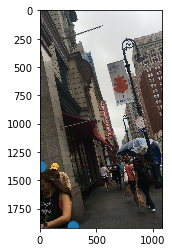

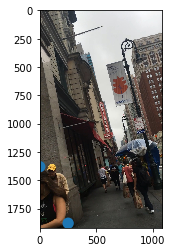

In [7]:
path_util.draw_box(good_boxes1[1], width1, height1, image_np1)
path_util.draw_box(good_boxes2[2], width2, height2, image_np2)